# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

Text8 Dataset: 31.4MB [01:06, 471KB/s]                                                                                                                                   


## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
## Your code here
from collections import Counter
import random

#threshold = 1e-5
#word_count = Counter(int_words)
#total_count_words = len(int_words)
#frequency = {word: count/total_count_words for word,count in word_count.items()}
#p_drop = {word: 1 - np.sqrt(threshold/frequency[word]) for word, count in word_count.items()}
                            
#train_words = [word for word in int_words if p_drop[word] < random.random()]# The final subsampled word list

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    # Your code here
    #start_index = 0
    #end_index = 0;
    #last_index = len(words)-1
    #to_pick = random.randint(1,window_size+1)
    #if (idx-window_size) < 0:
    #    start_index = 0
    #if (idx+end_index) > last_index:
    #    end_index = last_index
    #return words[start_index:end_index]

    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    print('no of batches' + str(n_batches))
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [10]:
n_vocab = len(int_to_vocab)
n_embedding =  200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), minval=-1, maxval=1))# create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, ids=inputs) # use tf.nn.embedding_lookup to get the hidden layer output

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1)) # create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros(n_vocab))# create softmax biases here
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [12]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [13]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [14]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
            sess.run(normalized_embedding)
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    print('normalizing embedding')
    embed_mat = sess.run(normalized_embedding)

no of batches4627
Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6397 0.8684 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6285 0.9423 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.5316 0.9384 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.6105 0.9239 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5091 0.9984 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5197 0.9212 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5400 0.9059 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5083 0.9173 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4654 0.8792 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4484 0.8791 sec/batch
Nearest to american: authorize, waging, evaporate, sparring, resonators, sg, cataria, micrometer,
Nearest to there: jezebel, worm, multivibrator, lying, fictions, musketeers, tentacle, bd,
Nearest to s: intellectualism, teutoburg, cdg, typology, lost, coordinating, theodoret, trai

Nearest to institute: grove, fonni, transjordan, teleology, islander, tenant, aged, eisenstein,
Nearest to smith: george, nominated, damon, jumpers, macias, jawaharlal, macintosh, kurzweil,
Nearest to award: bradbury, letters, cameo, accelerators, esterification, cease, schuster, multilateral,
Nearest to bill: simonds, alta, criminals, niki, speyer, hike, hauk, adolf,
Nearest to engine: screens, jpl, tian, stringing, saline, assassinated, evidentiary, finest,
Nearest to governor: botvinnik, denotation, rewrites, rosser, vendor, national, ambon, patrice,
Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.6837 0.8456 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.6606 0.8437 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.6381 0.8479 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 4.6280 0.8450 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 4.6199 0.8453 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 4.6397 0.8430 sec/batch
no of batches4

Nearest to three: two, one, four, est, five, rhodesia, zero, nine,
Nearest to who: conquests, tenant, soter, iers, advised, louisville, ind, invalid,
Nearest to can: normal, equivalent, reproduce, calyx, sensors, ducts, weighted, shanahan,
Nearest to are: different, lacks, inorganic, exogamy, carry, recipes, footer, construed,
Nearest to which: forte, alces, washed, glands, eeg, coelacanth, dragonfly, exposures,
Nearest to defense: retiring, commotion, reassure, carmichael, conquers, foreseen, fluoxetine, harass,
Nearest to assembly: elected, constitutional, augment, federal, equality, appoints, candidates, hoodoo,
Nearest to institute: tenant, grove, fonni, transjordan, griffiths, islander, teleology, hiroyuki,
Nearest to smith: damon, george, wally, grandfathers, jumpers, macias, nominated, selma,
Nearest to award: bradbury, honors, cameo, antonia, schuster, actors, caine, seu,
Nearest to bill: simonds, speyer, niki, alta, criminals, kanpur, law, ryerson,
Nearest to engine: screens, 

Epoch 3/10 Iteration: 11800 Avg. Training loss: 4.1580 0.8408 sec/batch
Epoch 3/10 Iteration: 11900 Avg. Training loss: 4.1413 0.8453 sec/batch
Epoch 3/10 Iteration: 12000 Avg. Training loss: 4.1449 0.8431 sec/batch
Nearest to american: economist, songwriter, natalie, winsor, kowloon, fenton, nellie, canadian,
Nearest to there: possibility, every, lying, westerly, cascadia, possible, clutter, linguistically,
Nearest to s: sung, fleetwood, intellectualism, epicureanism, misdirection, proposed, pay, postal,
Nearest to three: two, four, one, five, zero, six, est, eight,
Nearest to who: soter, invalid, advised, ind, tenant, conquests, solitude, sinned,
Nearest to can: reproduces, calyx, normal, wipes, reproduce, equivalent, generalize, weighted,
Nearest to are: different, lacks, exogamy, inorganic, footer, construed, intermarriage, cygni,
Nearest to which: washed, exposures, illusion, alces, glands, semiconductors, eeg, dundurn,
Nearest to defense: commotion, missile, harass, servicemen, r

Nearest to governor: elected, delegate, incumbent, officer, national, prime, szl, botvinnik,
Epoch 4/10 Iteration: 15100 Avg. Training loss: 4.0228 0.8522 sec/batch
Epoch 4/10 Iteration: 15200 Avg. Training loss: 4.0275 0.8431 sec/batch
Epoch 4/10 Iteration: 15300 Avg. Training loss: 4.0072 0.8388 sec/batch
Epoch 4/10 Iteration: 15400 Avg. Training loss: 4.0676 0.8409 sec/batch
Epoch 4/10 Iteration: 15500 Avg. Training loss: 4.0806 0.8429 sec/batch
Epoch 4/10 Iteration: 15600 Avg. Training loss: 4.0469 0.8423 sec/batch
Epoch 4/10 Iteration: 15700 Avg. Training loss: 4.0846 0.8400 sec/batch
Epoch 4/10 Iteration: 15800 Avg. Training loss: 4.1136 0.8409 sec/batch
Epoch 4/10 Iteration: 15900 Avg. Training loss: 4.0482 0.8428 sec/batch
Epoch 4/10 Iteration: 16000 Avg. Training loss: 4.0567 0.8404 sec/batch
Nearest to american: songwriter, winsor, economist, natalie, canadian, collaborated, athlete, kowloon,
Nearest to there: possibility, every, perturbations, older, westerly, lying, linguis

Nearest to defense: missile, commotion, ballistic, typically, yassir, downed, bomb, dodecylcyclobutanone,
Nearest to assembly: appoints, elected, edo, constitutional, legislature, shakespeare, schwenkfeld, augment,
Nearest to institute: pei, honorary, graduates, academy, university, grove, oxford, teleology,
Nearest to smith: kurzweil, damon, sampo, albeit, benson, george, macintosh, stylization,
Nearest to award: awards, nominated, bradbury, honors, best, caine, seu, hartford,
Nearest to bill: sza, simonds, niki, ryerson, criminals, prosecutors, law, wondrous,
Nearest to engine: piston, mechanically, stroke, macs, jpl, cooled, vw, prototype,
Nearest to governor: officer, incumbent, ashmole, disinterest, banished, szl, botvinnik, elected,
Epoch 5/10 Iteration: 19100 Avg. Training loss: 3.9594 0.8508 sec/batch
Epoch 5/10 Iteration: 19200 Avg. Training loss: 3.9402 0.8427 sec/batch
Epoch 5/10 Iteration: 19300 Avg. Training loss: 4.0300 0.8426 sec/batch
Epoch 5/10 Iteration: 19400 Avg. Tr

Nearest to s: a, zero, postal, nine, infty, contributed, soldiers, epicureanism,
Nearest to three: two, four, zero, one, five, six, eight, nine,
Nearest to who: unbelievers, toland, invalid, declined, advised, shame, ind, female,
Nearest to can: wipes, reproduces, calyx, might, bounce, choose, reflexive, precludes,
Nearest to are: different, lacks, all, carry, exogamy, nasrani, in, phonological,
Nearest to which: washed, as, intuitions, hexen, ordinary, glands, usaid, forte,
Nearest to defense: commotion, missile, downed, dodecylcyclobutanone, yassir, ballistic, prosecutorial, intervarsity,
Nearest to assembly: elected, edo, appoints, schwenkfeld, shakespeare, column, legislature, mps,
Nearest to institute: honorary, graduates, pei, university, griffiths, massachusetts, teleology, dr,
Nearest to smith: kurzweil, damon, albeit, macintosh, sampo, camillo, stylization, jawaharlal,
Nearest to award: awards, nominated, best, honors, bradbury, nominations, caine, oscars,
Nearest to bill: sza

Epoch 6/10 Iteration: 26700 Avg. Training loss: 3.8960 0.8500 sec/batch
Epoch 6/10 Iteration: 26800 Avg. Training loss: 4.0124 0.8484 sec/batch
Epoch 6/10 Iteration: 26900 Avg. Training loss: 4.0134 0.8463 sec/batch
Epoch 6/10 Iteration: 27000 Avg. Training loss: 3.9931 0.8473 sec/batch
Nearest to american: winsor, natalie, canadian, athlete, writer, osteopathic, songwriter, economist,
Nearest to there: every, possibility, no, dividend, are, perturbations, older, whistle,
Nearest to s: a, epicureanism, contributed, postal, mahommed, from, nine, dedication,
Nearest to three: two, four, zero, one, five, six, nine, eight,
Nearest to who: unbelievers, toland, advised, declined, pranksters, female, solitude, shame,
Nearest to can: wipes, calyx, veto, reproduces, bounce, might, choose, surf,
Nearest to are: all, different, lacks, exogamy, areas, pursuits, there, glottalized,
Nearest to which: washed, hexen, as, ordinary, alluvium, cosmodrome, the, inspect,
Nearest to defense: intervarsity, p

Epoch 7/10 Iteration: 30100 Avg. Training loss: 3.9244 0.8514 sec/batch
Epoch 7/10 Iteration: 30200 Avg. Training loss: 3.9444 0.8495 sec/batch
Epoch 7/10 Iteration: 30300 Avg. Training loss: 3.9121 0.8569 sec/batch
Epoch 7/10 Iteration: 30400 Avg. Training loss: 3.8743 0.8495 sec/batch
Epoch 7/10 Iteration: 30500 Avg. Training loss: 3.9465 0.8482 sec/batch
Epoch 7/10 Iteration: 30600 Avg. Training loss: 3.8981 0.8471 sec/batch
Epoch 7/10 Iteration: 30700 Avg. Training loss: 3.9077 0.8489 sec/batch
Epoch 7/10 Iteration: 30800 Avg. Training loss: 3.8823 0.8690 sec/batch
Epoch 7/10 Iteration: 30900 Avg. Training loss: 3.9037 0.8482 sec/batch
Epoch 7/10 Iteration: 31000 Avg. Training loss: 3.8576 0.8468 sec/batch
Nearest to american: natalie, osteopathic, winsor, authorize, spoofs, canadian, outweighed, sparring,
Nearest to there: every, are, no, possibility, and, older, have, perturbations,
Nearest to s: a, of, postal, from, epicureanism, and, its, the,
Nearest to three: two, four, five,

Nearest to bill: sza, derive, rockstar, criminals, speyer, jolene, prosecutors, niki,
Nearest to engine: stroke, cooled, piston, mechanically, engines, vw, shaft, pickup,
Nearest to governor: withheld, officer, nonresident, mbasogo, sainsbury, incumbent, disinterest, convenes,
Epoch 8/10 Iteration: 34100 Avg. Training loss: 3.8630 0.8745 sec/batch
Epoch 8/10 Iteration: 34200 Avg. Training loss: 3.8621 0.8744 sec/batch
Epoch 8/10 Iteration: 34300 Avg. Training loss: 3.9055 0.8696 sec/batch
Epoch 8/10 Iteration: 34400 Avg. Training loss: 3.9157 0.8702 sec/batch
Epoch 8/10 Iteration: 34500 Avg. Training loss: 3.8833 0.8692 sec/batch
Epoch 8/10 Iteration: 34600 Avg. Training loss: 3.8693 0.8725 sec/batch
Epoch 8/10 Iteration: 34700 Avg. Training loss: 3.8934 0.8614 sec/batch
Epoch 8/10 Iteration: 34800 Avg. Training loss: 3.8820 0.8531 sec/batch
Epoch 8/10 Iteration: 34900 Avg. Training loss: 3.8903 0.8481 sec/batch
Epoch 8/10 Iteration: 35000 Avg. Training loss: 3.9087 0.8522 sec/batch
Ne

Nearest to institute: honorary, graduates, dr, champaign, mullin, university, postdoctoral, drexler,
Nearest to smith: developed, kurzweil, jawaharlal, albeit, sunsets, nehemiah, grisly, macintosh,
Nearest to award: awards, best, nominated, honors, won, nominations, oscars, outstanding,
Nearest to bill: sza, derive, speyer, rockstar, jolene, niki, criminals, jk,
Nearest to engine: stroke, piston, cooled, engines, mechanically, shaft, vw, pressurized,
Nearest to governor: withheld, nonresident, officer, sainsbury, newton, mbasogo, cornelius, ashmole,
Epoch 9/10 Iteration: 38100 Avg. Training loss: 3.8807 0.8478 sec/batch
Epoch 9/10 Iteration: 38200 Avg. Training loss: 3.7487 0.8429 sec/batch
Epoch 9/10 Iteration: 38300 Avg. Training loss: 3.8411 0.8426 sec/batch
Epoch 9/10 Iteration: 38400 Avg. Training loss: 3.7865 0.8402 sec/batch
Epoch 9/10 Iteration: 38500 Avg. Training loss: 3.8176 0.8443 sec/batch
Epoch 9/10 Iteration: 38600 Avg. Training loss: 3.8545 0.8403 sec/batch
Epoch 9/10 I

Nearest to defense: offensive, ministry, simile, maga, abbreviate, intervarsity, guard, dodecylcyclobutanone,
Nearest to assembly: gigabytes, schwenkfeld, legislature, branch, hatha, codification, sweetest, bathe,
Nearest to institute: honorary, graduates, university, dr, cam, mullin, champaign, postdoctoral,
Nearest to smith: kurzweil, jawaharlal, developed, albeit, sunsets, benson, macintosh, grisly,
Nearest to award: awards, best, nominated, honors, nominations, won, oscars, hugo,
Nearest to bill: sza, speyer, derive, rockstar, prosecutors, absolutely, jk, jolene,
Nearest to engine: stroke, piston, engines, mechanically, cooled, shaft, pump, vw,
Nearest to governor: withheld, officer, ashmole, nonresident, newton, rockefeller, mathis, cornelius,
Epoch 10/10 Iteration: 42100 Avg. Training loss: 3.8015 1.0173 sec/batch
Epoch 10/10 Iteration: 42200 Avg. Training loss: 3.8302 1.0236 sec/batch
Epoch 10/10 Iteration: 42300 Avg. Training loss: 3.8208 0.9650 sec/batch
Epoch 10/10 Iteration:

Nearest to defense: offensive, ministry, simile, maga, abbreviate, agency, guard, dodecylcyclobutanone,
Nearest to assembly: schwenkfeld, branch, legislature, codification, sweetest, gigabytes, elected, bathe,
Nearest to institute: university, mullin, dr, graduates, honorary, academy, champaign, harpercollins,
Nearest to smith: jawaharlal, kurzweil, developed, albeit, nehemiah, grisly, benson, macintosh,
Nearest to award: awards, best, nominated, honors, nominations, won, oscars, academy,
Nearest to bill: speyer, sza, derive, rockstar, absolutely, rusty, jolene, jk,
Nearest to engine: piston, cooled, engines, stroke, mechanically, pressurized, shaft, arminians,
Nearest to governor: withheld, officer, nonresident, newton, rockefeller, ashmole, mbasogo, injury,
Epoch 10/10 Iteration: 46100 Avg. Training loss: 3.8151 0.8651 sec/batch
Epoch 10/10 Iteration: 46200 Avg. Training loss: 3.8196 0.8634 sec/batch
normalizing embedding


Restore the trained network if you need to:

In [15]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

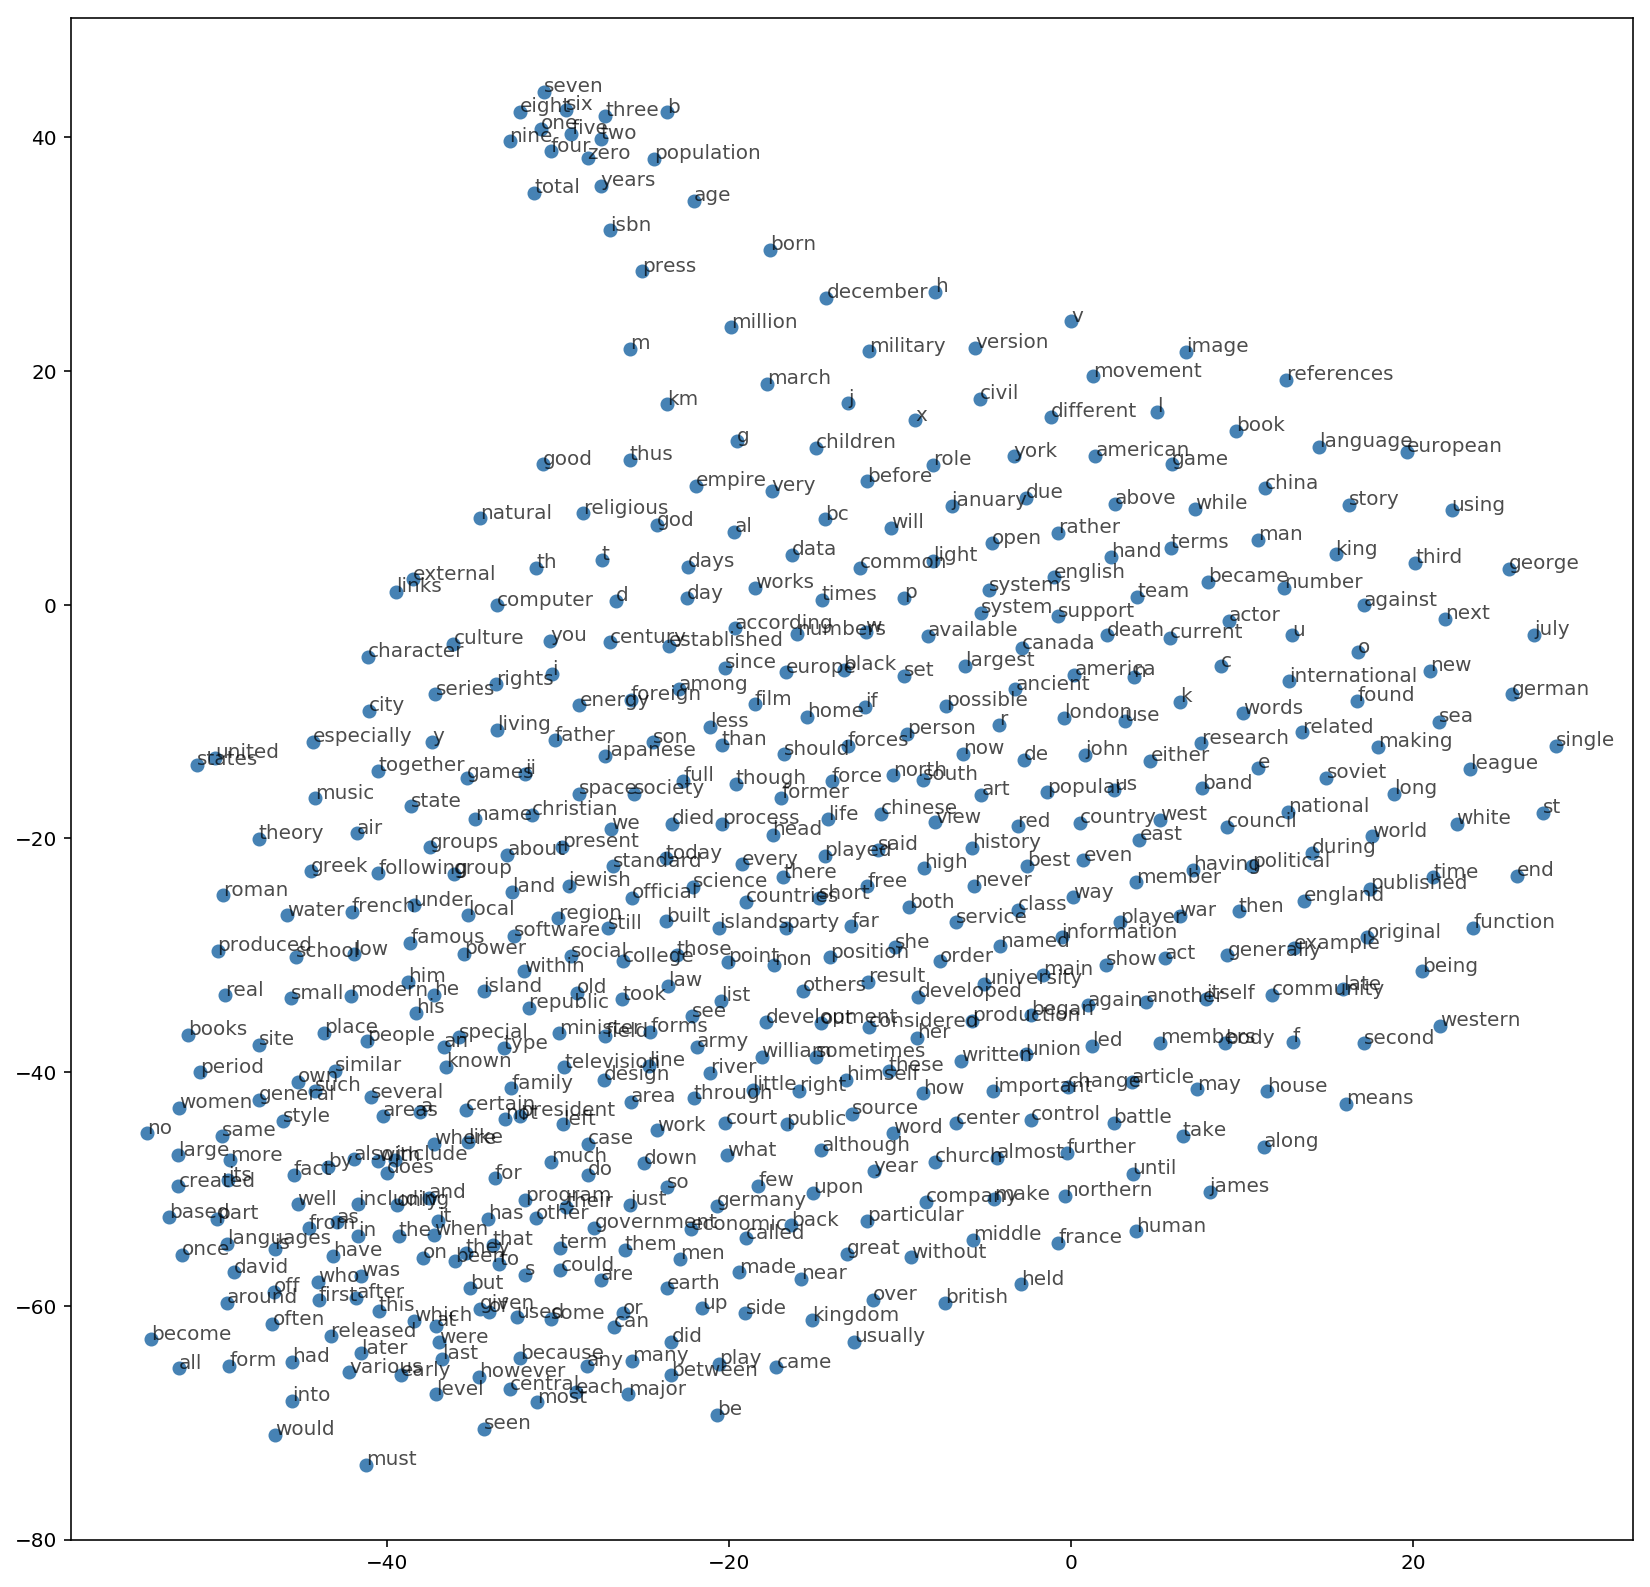

In [18]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)